In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix
import timeit

In [2]:
def data_process(data):
    features = data[:,:-1]
    #features = sklearn.preprocessing.StandardScaler().fit_transform(features)
    #features = sklearn.preprocessing.normalize(features)
    data[:,:-1] = features
    return data

def accuracy(y, y_pred):
    return sum(y == y_pred)/len(y)

def mc_hinge(W,x,y):

    '''
    w_i - vector of weights of the SVM for the class i; W has |features| rows and |classes| columns
    x - features of a sample
    y - label of a sample
    loss = max{0, max(w_j*x - w_y*x)}, j={0,...,|classes|-1}, j!=y
    output - hingle loss value and the corresponding w_j index
    '''

    n_features, n_class = np.shape(W)
    wyx = W[:,y].dot(x)
    max_dif = - np.inf
    ind_j = 0

    for j in [i for i in range(n_class) if i != y]:
        wjx = W[:,j].dot(x)
        if wjx > max_dif:
            max_dif = wjx
            ind_j = j

    max_dif -= wyx

    if max_dif > 0:
        return 1 + max_dif, ind_j
    else:
        return 0, -1

In [11]:
class LinearSVM:
            
    def fit(self, dataset, learning_rate, epochs, regularization):
        
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        w = np.random.rand(size)        
        w_epochs = np.zeros((epochs, size))       
        
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
                        
            for j in range(len(dataset)):

                x = X[j]                
                y = Y[j]
        
                ywx = y * w.dot(x) 
                    
                if ywx < 1:
                    gradient = (2 * regularization * w) / n - y*x
                else:
                    gradient = (2 * regularization * w) / n
                
                w = w - learning_rate * gradient
            
            w_epochs[i] = w
        
        return w, w_epochs
        
    def predict(self, dataset, w):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)

        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]
        
        for i in range(len(dataset)):
            y[i] = np.sign(np.dot(dataset[i],w))
        return y
    
    def plot_accuracies(self, train_dataset, test_dataset, w_epochs):
        epochs = len(w_epochs)
        test_accuracies = np.zeros(epochs)
        train_accuracies = np.zeros(epochs)
        for i in range(epochs):
            train_labels = self.predict(train_dataset, w_epochs[i])
            test_labels = self.predict(test_dataset, w_epochs[i])
            train_accuracies[i] = accuracy(train_dataset[:,-1], train_labels)
            test_accuracies[i] = accuracy(test_dataset[:,-1], test_labels)
            

        xs = np.array(range(epochs))+1
        fig = plt.figure(figsize=(7,7))
        ax = plt.axes()
        ax.set(xlabel="epochs", ylabel="accuracy", ylim=(0,1.1))
        line = ax.plot(xs, train_accuracies, marker='.', label='training') #, marker='o'
        line = ax.plot(xs, test_accuracies, marker='.', label='validation') #, marker='o'
        ax.legend()
        plt.title("Accuracy over Epochs")
        plt.show()



In [22]:
class LinearSVM_MC:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization, n_class):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        size = len(dataset[0])-1
        n = len(dataset)
        
        W = np.random.rand(size, n_class)       
        
        # this array stores the W matrix after each epoch
        W_epochs = np.zeros((epochs, size, n_class))       
        
        w_norms = []

        X = dataset[:,:-1]
        Y = dataset[:,-1]
        
        for i in range(epochs):
            
            shuffle = np.random.permutation(n)
            X = X[shuffle]
            Y = Y[shuffle]
            
            for j in range(len(dataset)):
                x = X[j]                
                y = int(Y[j])
                
                gradient = np.zeros([size, n_class])
        
                temp, k = mc_hinge(W, x, y)
                    
                if temp > 0:
                    
                    gradient[:,y] = -x

                    gradient[:,k] = x
                    
                
                W = W - learning_rate * (gradient + (2 * regularization * W) / n)
                
                
                '''
                W = W - learning_rate * gradient / n
                
                temp = np.linalg.norm(W, ord='fro')
                if temp > 1/regularization:
                    W /= (temp * regularization)
                '''
            W_epochs[i] = W
            
        w_norms = np.array(w_norms)
        
        return W, W_epochs
        
    def predict(self, dataset, W):
        # adding ones at the end of each feature vector
        dataset = np.insert(dataset, -1, np.ones(len(dataset)), axis=1)
        
        y = np.zeros(len(dataset)) 
        dataset = dataset[:,:-1]

        for i in range(len(dataset)):
            y[i] = np.argmax(np.dot(W.T, dataset[i]))
        return y
    
    
    def plot_accuracies(self, train_dataset, test_dataset, W_epochs):
        epochs = len(W_epochs)
        test_accuracies = np.zeros(epochs)
        train_accuracies = np.zeros(epochs)
        for i in range(epochs):
            train_labels = self.predict(train_dataset, W_epochs[i])
            test_labels = self.predict(test_dataset, W_epochs[i])
            train_accuracies[i] = accuracy(train_dataset[:,-1], train_labels)
            test_accuracies[i] = accuracy(test_dataset[:,-1], test_labels)
            

        xs = np.array(range(epochs))+1
        fig = plt.figure(figsize=(7,7))
        ax = plt.axes()
        ax.set(xlabel="epochs", ylabel="accuracy", ylim=(0,1.1))
        line = ax.plot(xs, train_accuracies, marker='.', label='training') #, marker='o'
        line = ax.plot(xs, test_accuracies, marker='.', label='validation') #, marker='o'
        ax.legend()
        plt.title("Accuracy over Epochs")
        plt.show()


In [13]:
def cross_validation(SVM_object, dataset, no_subsets, learning_rate, epochs, regularization):
    accuracies = np.zeros(no_subsets)
    mean_duration = 0
    # split dataset into no_subsets chunks. Chunks must be of euqal size, otherwise an error is raised
    subarrays = np.split(dataset, no_subsets, axis=0)
    
    # pick one subset as test set and train the model with the rest. Then calculate the accuracy on the test set
    for i in range(no_subsets):
        train_set = np.concatenate(subarrays[:i] + subarrays[i+1:], axis=0)
        test_set = subarrays[i]
        
        start = timeit.default_timer()
        
        w, w_epochs = SVM_object.fit(train_set, learning_rate, epochs, regularization)
        
        stop = timeit.default_timer()
        mean_duration += stop - start
        
        test_labels_pred = SVM_object.predict(test_set, w)
        accuracies[i] = accuracy(test_set[:,-1], test_labels_pred)
    
    mean_duration /= no_subsets
    # return the average accuracy
    return np.mean(accuracies), mean_duration

### Dual-Class linear SVM

#### Tiny Toy-Dataset

In [14]:
# read the small toy-dataset and apply preconditioning
toydata_tiny = pd.read_csv('toydata_tiny.csv').to_numpy()
toydata_tiny = data_process(toydata_tiny)

In [15]:
# create the SVM model and fit set the parameters
mySVM_tiny = LinearSVM()
regularization = 0.1
learning_rate = 1
epochs = 10

In [16]:
# apply 5 fold cross validation. 
no_subsets = 5
cross_val_accuracy, mean_duration = cross_validation(mySVM_tiny, toydata_tiny, no_subsets, learning_rate, epochs, regularization)
print('Average time for fitting the model: ', mean_duration, 's')  
print("Average Accuracy: " + str(cross_val_accuracy))

Average time for fitting the model:  0.009398538399997847 s
Average Accuracy: 0.9949999999999999


plotting the convergence, i.e. the accuracy over the number of epochs 

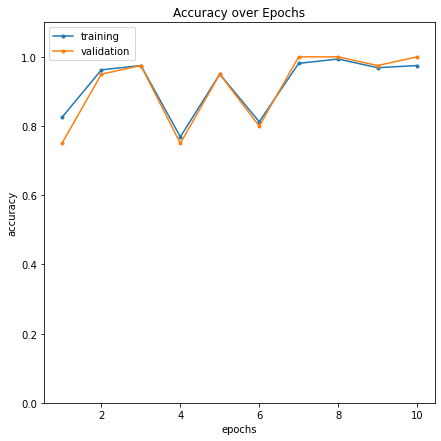

In [17]:
# create random indices from 0 to len(toydata_tiny) 
idx_arr = np.array(range(len(toydata_tiny)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(toydata_tiny))

#split training and test set from toydata_tiny
train_set_tiny = toydata_tiny[idx_arr[:-testsize]]
test_set_tiny = toydata_tiny[idx_arr[-testsize:]]

# fit the model with the training set
w, w_epochs = mySVM_tiny.fit(train_set_tiny, learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_tiny.plot_accuracies(train_set_tiny, test_set_tiny, w_epochs)

#### Large Toy-Dataset

In [18]:
# read the large toy-dataset and apply preconditioning
toydata_large = pd.read_csv('toydata_large.csv').to_numpy()
toydata_large = data_process(toydata_large)

In [19]:
# create the SVM model and fit set the parameters
mySVM_large = LinearSVM()
regularization = 0.1
learning_rate = 1
epochs = 10

In [20]:
# apply 5 fold cross validation. 
no_subsets = 5


cross_val_accuracy, mean_duration = cross_validation(mySVM_large, toydata_large, no_subsets, learning_rate, epochs, regularization)


print('Average time for fitting the model: ', mean_duration, 's')  

print("Average Accuracy: " + str(cross_val_accuracy))

Average time for fitting the model:  6.67793495520001 s
Average Accuracy: 0.9999649999999999


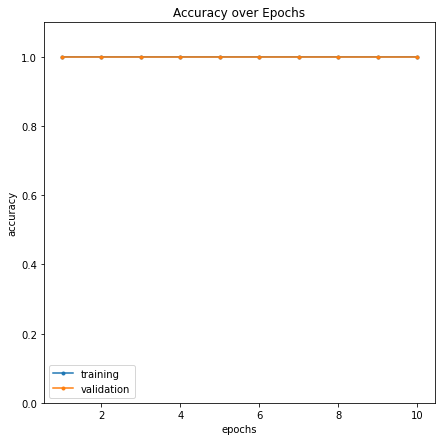

In [21]:
# create random indices from 0 to len(toydata_large) 
idx_arr = np.array(range(len(toydata_large)))
np.random.shuffle(idx_arr)

#set size of testset to be 20% of total dataset
testsize = round(0.2 * len(toydata_large))

#split training and test set from toydata_tiny
train_set_large = toydata_large[idx_arr[:-testsize]]
test_set_large = toydata_large[idx_arr[-testsize:]]

# fit the model with the training set
w, w_epochs = mySVM_large.fit(train_set_large, learning_rate, epochs, regularization)

# plot the accuracies over epochs
mySVM_large.plot_accuracies(train_set_large, test_set_large, w_epochs)

### Multiclass SVM

#### MNIST Dataset

In [23]:
# reading MNIST Date from file
data = np.load("mnist.npz")
train = data["train"].T
train_labels = data["train_labels"][0]
test = data["test"].T
test_labels = data["test_labels"][0]

# size of the validation set
validation_size = 10000

# creates a randomly shuffled indices
# the 60000 training dataset must be shuffled before a validation set can be separated from it
idx_arr = np.array(range(len(train_labels)))
np.random.shuffle(idx_arr)

# trainig data
mnist_train = np.zeros([len(train) - validation_size, len(train[0])+1])
mnist_train[:,:-1] = train[idx_arr[:-validation_size]]
mnist_train[:,-1] = train_labels[idx_arr[:-validation_size]]

# validation data
mnist_validation = np.zeros([validation_size, len(train[0])+1])
mnist_validation[:,:-1] = train[idx_arr[-validation_size:]]
mnist_validation[:,-1] = train_labels[idx_arr[-validation_size:]]

# test data (never touch)
#mnist_test = np.zeros([len(test), len(test[0])+1])
#mnist_test[:,:-1] = test
#mnist_test[:,-1] = test_labels

In [24]:
mySVM2 = LinearSVM_MC()
regularization = 0.1
learning_rate = 1
epochs = 10

start = timeit.default_timer()
W, W_epochs = mySVM2.fit(mnist_train, learning_rate, epochs, regularization, n_class=10)
stop = timeit.default_timer()

print('Time for fitting the model: ', stop - start)  

Time for fitting the model:  23.068756132000004


In [25]:
train_labels_predicted = mySVM2.predict(mnist_train, W)
accuracy(mnist_train[:,-1], train_labels_predicted)

0.84802

In [26]:
validation_labels_predicted = mySVM2.predict(mnist_validation, W)
accuracy(mnist_validation[:,-1], validation_labels_predicted)

0.8369

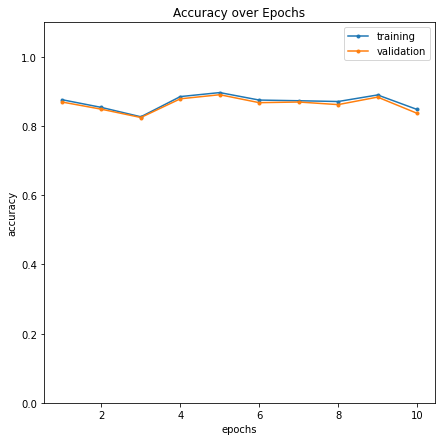

In [27]:
mySVM2.plot_accuracies(mnist_train, mnist_validation, W_epochs)

In [28]:
# plot confusion matrix
confusion_matrix(mnist_validation[:,-1], validation_labels_predicted) #,labels=[0,1,2,3,4,5,6,7,8,9]


array([[ 811,    1,   19,    1,    0,  113,   18,    4,   12,    1],
       [   0, 1044,   45,    3,    0,   26,    1,    4,    6,    0],
       [   1,    1,  953,    6,    3,   12,   17,    8,   10,    1],
       [   0,    4,   81,  708,    0,  190,    4,   18,   17,   13],
       [   1,    3,   24,    2,  718,   10,   46,   14,   40,   81],
       [  12,    4,   17,    9,    3,  815,   10,    7,   22,    4],
       [   3,    2,    7,    0,    1,   43,  914,    0,    3,    1],
       [   2,    4,   51,    2,    3,    2,    3,  964,    4,   32],
       [   2,   13,   78,   10,    0,  177,   16,    3,  685,    4],
       [   1,    3,    9,    3,   19,   53,    1,  103,   24,  757]])